In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO1d
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
from utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F

device = 'cpu'

In [2]:
# Subsampling rate
sampling_rate = 3
ntrain = 500
ntest = 50
batch_size = 10


In [40]:
data = np.load("data/ks_1d_data.npy").astype(np.float32)
grid_range = 1

x_data = torch.tensor(data[:,0])
y_data = torch.tensor(data[:,1])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain], y_data[:ntrain]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx = gridx.reshape(1, 1, size_x)

x_train = torch.cat((x_train, gridx.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

In [41]:
model = TFNO1d(n_modes_height=(16), hidden_channels=32, projection_channels=64,
             in_channels = 2, factorization='tucker', rank=0.42)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 47745 parameters.


In [42]:
l2loss = LpLoss(d=2, p=2)

eval_losses={'l2': l2loss}

# Training parameters
epochs = 20
batch_size = 20
learning_rate = 0.003
step_size = 50   # weight-decay step size
gamma = 0.5      # weight-decay rate

optimizer = torch.optim.Adam(model.parameters(),
                                lr=learning_rate,
                                weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [43]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x = sample["x"].to(device)
            y= sample["y"].to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-0.7545, Train-MSE-0.3039, Train-L2-0.0249, Test-L2-0.0129
Epoch-1, Time-0.7602, Train-MSE-0.0284, Train-L2-0.0084, Test-L2-0.0075
Epoch-2, Time-0.6962, Train-MSE-0.0137, Train-L2-0.0059, Test-L2-0.0068
Epoch-3, Time-0.6797, Train-MSE-0.0125, Train-L2-0.0056, Test-L2-0.0048
Epoch-4, Time-0.8453, Train-MSE-0.0056, Train-L2-0.0038, Test-L2-0.0039
Epoch-5, Time-0.6688, Train-MSE-0.0049, Train-L2-0.0035, Test-L2-0.0039
Epoch-6, Time-0.6546, Train-MSE-0.0063, Train-L2-0.0040, Test-L2-0.0047
Epoch-7, Time-0.6523, Train-MSE-0.0053, Train-L2-0.0037, Test-L2-0.0046
Epoch-8, Time-0.6529, Train-MSE-0.0057, Train-L2-0.0037, Test-L2-0.0059
Epoch-9, Time-0.6617, Train-MSE-0.0052, Train-L2-0.0036, Test-L2-0.0037
Epoch-10, Time-0.7533, Train-MSE-0.0027, Train-L2-0.0026, Test-L2-0.0036
Epoch-11, Time-0.7999, Train-MSE-0.0035, Train-L2-0.0029, Test-L2-0.0037
Epoch-12, Time-0.8093, Train-MSE-0.0027, Train-L2-0.0026, Test-L2-0.0029
Epoch-13, Time-0.7736, Train-MSE-0.0017, Train-L2-0.0021, Tes

In [44]:
# %%
""" Prediction """
pred = []
test_e = []
with torch.no_grad():
    
    index = 0
    for sample in test_loader:
        x = sample["x"].to(device)
        y= sample["y"].to(device)
        test_l2 = 0 

        out = model(x)
        test_l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

        test_e.append( test_l2/batch_size )
        pred.append( out )
        print("Batch-{}, Test-loss-{:0.6f}".format( index, test_l2/batch_size ))
        index += 1

pred = torch.cat((pred))
test_e = torch.tensor((test_e))  
print('Mean Error:', 100*torch.mean(test_e).numpy())

Batch-0, Test-loss-0.001605
Batch-1, Test-loss-0.001214
Batch-2, Test-loss-0.001737
Mean Error: 0.1518771518021822


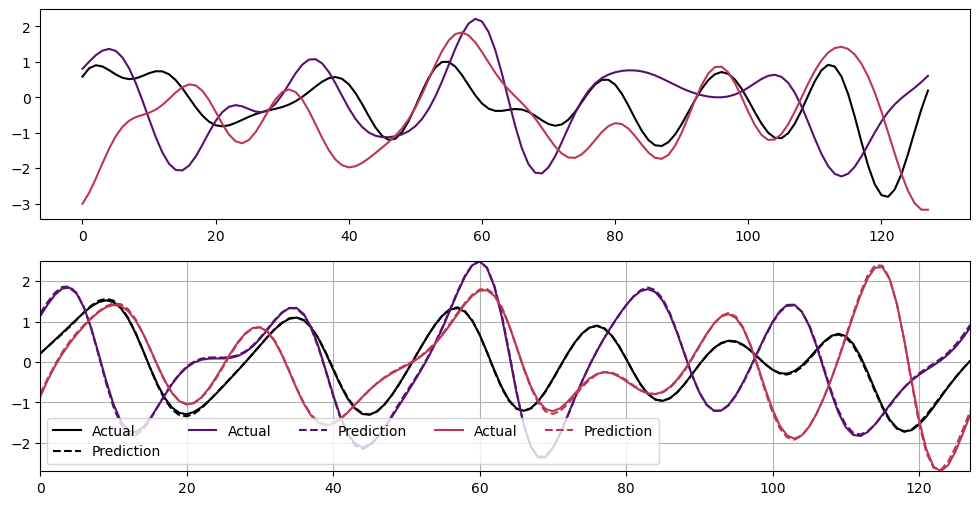

In [45]:
x_test, y_test = test_data
# %%


colormap = plt.cm.inferno
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(y_test.shape[0]):
    if i % 20 == 1:
        axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
        axs[1].plot(pred[i,0].cpu().numpy(), '--', color=colors[index], label='Prediction')
        axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
        index += 1
plt.legend(ncol=5)
plt.grid(True)
plt.margins(0)

# PFNO